In [1]:
! pip install pandas
! pip install boto3
! pip install watchtower
! pip install s3fs
! pip install pyathena
! pip install matplotlib
! pip install scipy
! pip install ipywidgets
! pip install scikit-learn

! conda install -c conda-forge --yes implicit 

! pip install --upgrade jupyter_client # useful to make ipywidgets work properly when fitting data with implicit

# pip install git+https://gitlab.com/cloena/cloena-aws-tools.git

     |████████████████████████████████| 10.0 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 108.9 MB/s eta 0:00:01
     |████████████████████████████████| 20.6 MB 84.7 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 19.4 MB/s eta 0:00:01
  Using cached s3transfer-0.3.3-py2.py3-none-any.whl (69 kB)
     |████████████████████████████████| 6.2 MB 19.4 MB/s eta 0:00:01
  Using cached jmespath-0.9.5-py2.py3-none-any.whl (24 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Using cached urllib3-1.25.9-py2.py3-none-any.whl (126 kB)
     |████████████████████████████████| 70 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 23.1 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=90f4b76bf121276912f0d6ffe92130c6914db705bf4648371da020e6cccb2fb1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8e

In [2]:
import pandas as pd

import implicit

from aws_tools import athena_tools, s3_tools

import matplotlib

import re

import scipy

from ipywidgets import FloatProgress

import numpy as np

from sklearn.preprocessing import MinMaxScaler

/home/ec2-user/anaconda3/envs/pg_tv/lib/python3.8/site-packages/aws_tools/project_config.py:18: UserWarning: no aws_config.json file found
  warnings.warn('no aws_config.json file found')


In [3]:
query = """
SELECT LINE_ACCOUNT_ID, PRODUCT_ID, CI_TITLE, CI_ASSET_TYPE, ENTITLEMENT_TYPE, CI_PRICE, PURCHASE_TIME_ST
FROM bt_home_datamart.l_edw_vod_purchases
WHERE   (ENTITLEMENT_TYPE LIKE 'EVOD' OR ENTITLEMENT_TYPE LIKE 'TVOD');
"""
data_master = athena_tools.AthenaQuerier().execute_query(query=query)

'''(PURCHASE_ENTITLEMENT_START_DT < CAST('2019-10-01' AS DATE)) 
    AND (PURCHASE_ENTITLEMENT_START_DT > CAST('2019-08-31' AS DATE)) 
    AND '''

2020-05-01 08:26:44,671 [INFO ]  starting Athena query ...
2020-05-01 08:27:08,070 [INFO ]  Athena query complete


"(PURCHASE_ENTITLEMENT_START_DT < CAST('2019-10-01' AS DATE)) \n    AND (PURCHASE_ENTITLEMENT_START_DT > CAST('2019-08-31' AS DATE)) \n    AND "

In [4]:
# Make a copy to manipulate
data = data_master.copy()

In [5]:
del data_master

In [6]:
print(data.shape)
data.head()

(2284641, 7)


,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
0,BBEU36130222,BBJ378420A,Grand Piano,Music,TVOD,0.30,2020-02-05 00:47:06
1,BBEU03226964,9316262,IT Chapter Two,Film,TVOD,4.49,2020-02-05 00:28:20
2,BBEU29903583,4541838,Legend,Film,TVOD,3.50,2020-02-05 00:44:31
3,BBEU36171318,BBJ889346A,The Last House on the Left,Film,EVOD,7.99,2020-02-05 01:11:34
4,BBEU05328730,9108794,The Mustang,Film,TVOD,3.49,2020-02-05 04:33:22


In [7]:
# Eliminate some duplicates from content items (e.g. different episodes/serieses or special editions)
print(data[data['CI_TITLE'].str.contains(" S\d{1,3}-E\d{1,3}")]['CI_TITLE'].value_counts().sort_index())
print()
print(data[data['CI_TITLE'].str.contains(" Series \d{1,3}")]['CI_TITLE'].value_counts().sort_index())
print()
print(data[data['CI_TITLE'].str.contains(" \[\w+ \w+\]")]['CI_TITLE'].value_counts().sort_index())
print()
print(data[data['CI_TITLE'].str.contains(" - HD")]['CI_TITLE'].value_counts().sort_index())   
print()
print(data[data['CI_TITLE'].str.contains(" - Volume")]['CI_TITLE'].value_counts().sort_index()) 
print()
print(data[data['CI_TITLE'].str.contains(" - Episode")]['CI_TITLE'].value_counts().sort_index()) 
print()
print(data[data['CI_TITLE'].str.contains(" - ")]['CI_TITLE'].value_counts().sort_index()) 
print()
print(data[data['CI_TITLE'].str.contains(" Movie Collection")]['CI_TITLE'].value_counts().sort_index()) 
print(data[data['CI_TITLE'].str.contains(" Mini-Movie Collection")]['CI_TITLE'].value_counts().sort_index()) 
print(data[data['CI_TITLE'].str.contains(" Film Collection")]['CI_TITLE'].value_counts().sort_index()) 
print(data[data['CI_TITLE'].str.contains("Boxset")]['CI_TITLE'].value_counts().sort_index()) 

100 Code S1-E1 Pilot                                  26
100 Code S1-E10 Secrets                                2
100 Code S1-E11 Still Living After All                 2
100 Code S1-E12 Everytime You Think You're Winning     2
100 Code S1-E2 Flowers in Hell                         3
                                                      ..
the Sopranos S4-E5 Pie-o-My                            7
the Sopranos S4-E6 Everybody Hurts                     4
the Sopranos S4-E7 Watching Too Much Television        5
the Sopranos S4-E8 Mergers and Acquisitions            4
the Sopranos S4-E9 Whoever Did This                    6
Name: CI_TITLE, Length: 10923, dtype: int64

100 Code Series 1                  21
11.22.63 Series 1                  27
12 Monkeys Series 1                21
12 Monkeys Series 2                 5
12 Monkeys Series 3                 4
                                   ..
ZQX H5 2019 V3 S01 EST Series 1     2
ZQX H5 2019 V3 S02 EST Series 2     1
ZQXD1 PT1 Series 1      

In [8]:
def clean_titles(x):
    
    x = x.lower()
    
    x = re.split(' \[\w+ \w+\]', x)[0]
    x = re.split(' s\d{1,3}-e\d{1,3}', x)[0]
    x = re.split(' s\d{1,3}-\d{1,3}', x)[0]
    x = re.split(' series \d{1,3}', x)[0]
    x = re.split(' - hd', x)[0]
    x = re.split(' - volume', x)[0]
    x = re.split(' - episode', x)[0]
    x = re.split(' - ', x)[0]
    x = re.split(' movie collection', x)[0]
    x = re.split(' mini-movie collection', x)[0]
    x = re.split(' film collection', x)[0]
    x = re.split(' boxset', x)[0]
    
    x = x.rstrip() # removes all whitespaces at the end of a string (just in case any string has them)
    
    return x

data['CI_TITLE'] = data['CI_TITLE'].apply(clean_titles)

In [9]:
# Explore what types of asset and entitlement we have
print(data['CI_ASSET_TYPE'].value_counts().sort_values(ascending=False))
print()
print(data['ENTITLEMENT_TYPE'].value_counts().sort_values(ascending=False))

Film     2023277
TV        177175
Music      51582
Kids       32594
Sport         11
Name: CI_ASSET_TYPE, dtype: int64

TVOD    1511575
EVOD     773066
Name: ENTITLEMENT_TYPE, dtype: int64


In [10]:
# Make entitlement explcit: i.e. purchase or rental
data['ENTITLEMENT_TYPE'] = data['ENTITLEMENT_TYPE'].apply(lambda x: 'Purchase' if x == 'EVOD' else ('Rental' if x == 'TVOD' else x))

data.head()

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
0,BBEU36130222,BBJ378420A,grand piano,Music,Rental,0.30,2020-02-05 00:47:06
1,BBEU03226964,9316262,it chapter two,Film,Rental,4.49,2020-02-05 00:28:20
2,BBEU29903583,4541838,legend,Film,Rental,3.50,2020-02-05 00:44:31
3,BBEU36171318,BBJ889346A,the last house on the left,Film,Purchase,7.99,2020-02-05 01:11:34
4,BBEU05328730,9108794,the mustang,Film,Rental,3.49,2020-02-05 04:33:22


In [11]:
# Create unique IDs for users and content, starting from 1
data['LINE_ACCOUNT_ID'], uniques_accounts = pd.factorize(data['LINE_ACCOUNT_ID'])
data['PRODUCT_ID'], uniques_products = pd.factorize(data['CI_TITLE']) # overwrite as product ID is not unique but ci_title seems to be

In [12]:
print(data.shape)
data.head()

(2284641, 7)


,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
0,0,0,grand piano,Music,Rental,0.30,2020-02-05 00:47:06
1,1,1,it chapter two,Film,Rental,4.49,2020-02-05 00:28:20
2,2,2,legend,Film,Rental,3.50,2020-02-05 00:44:31
3,3,3,the last house on the left,Film,Purchase,7.99,2020-02-05 01:11:34
4,4,4,the mustang,Film,Rental,3.49,2020-02-05 04:33:22


In [13]:
# Look at accounts that placed the most purchases/rentals
data['LINE_ACCOUNT_ID'].value_counts().sort_values(ascending=False)[:10]

-1        17205
 55631     2702
 18005     2678
 9608      1776
 1981      1562
 25455      991
 13180      981
 1640       685
 2587       678
 7427       643
Name: LINE_ACCOUNT_ID, dtype: int64

In [14]:
# Look at products (actual title names) that have the most purchases/rentals
prod_ids_tocheck = list(data['PRODUCT_ID'].value_counts().sort_values(ascending=False)[:10].index)
print(prod_ids_tocheck)

data[data['PRODUCT_ID'].isin(prod_ids_tocheck)].head()

[3253, 78, 278, 389, 273, 459, 163, 445, 631, 5]


,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
5,5,5,joker,Film,Purchase,15.99,2020-02-05 07:04:24
40,37,5,joker,Film,Purchase,15.99,2020-02-05 10:10:31
79,63,5,joker,Film,Purchase,15.99,2020-02-05 10:22:24
92,71,5,joker,Film,Purchase,15.99,2020-02-05 06:42:33
102,78,78,the walking dead,TV,Purchase,20.99,2020-02-05 06:54:49


In [15]:
# Exclude rows that had missing account id or product id (for whcih the pd.factorize turned them into -1)
data = data[(data['LINE_ACCOUNT_ID'] != -1) & (data['PRODUCT_ID'] != -1)]

print(data.shape)
data.head()

(2267436, 7)


,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
0,0,0,grand piano,Music,Rental,0.30,2020-02-05 00:47:06
1,1,1,it chapter two,Film,Rental,4.49,2020-02-05 00:28:20
2,2,2,legend,Film,Rental,3.50,2020-02-05 00:44:31
3,3,3,the last house on the left,Film,Purchase,7.99,2020-02-05 01:11:34
4,4,4,the mustang,Film,Rental,3.49,2020-02-05 04:33:22


2020-05-01 08:27:42,378 [INFO ]  generated new fontManager


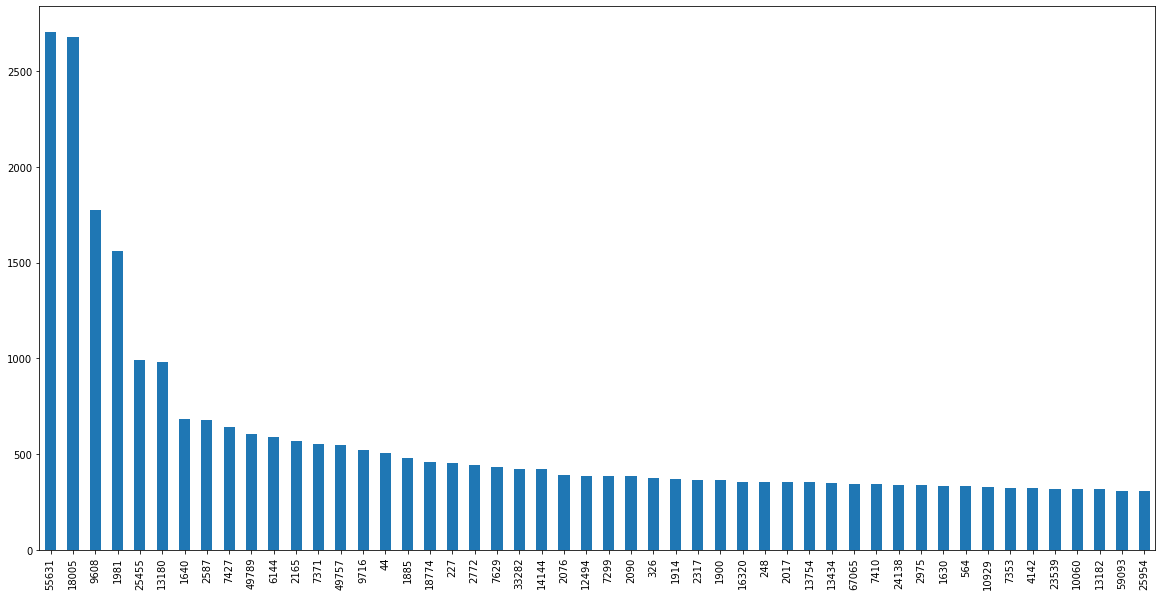

In [16]:
# Visualise users by number of purchases/rentals
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

data['LINE_ACCOUNT_ID'].value_counts()[:50].plot(kind='bar')

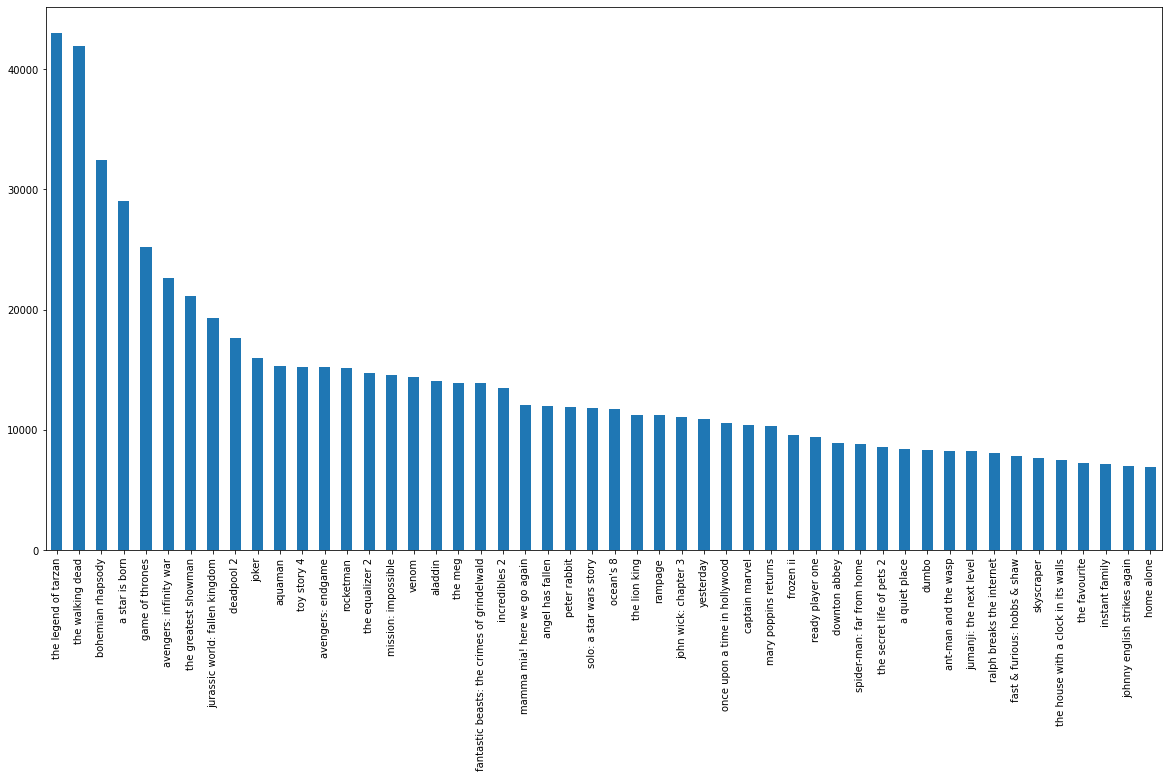

In [17]:
# Visualise content items by number of purchases/rentals
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

data['CI_TITLE'].value_counts()[:50].plot(kind='bar')

In [18]:
# Let's explore what user 1315 bought...
data[data['LINE_ACCOUNT_ID'] == 1315].head(20) # >>> it seems a lot of music videos

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
1477,1315,607,damsel,Film,Rental,3.49,2019-05-04 18:27:23
26636,1315,36,the shape of water,Film,Rental,3.49,2018-10-13 19:40:02
66419,1315,906,dino time,Film,Rental,0.99,2020-03-14 09:41:57
286331,1315,4151,hell on the border,Film,Rental,3.49,2020-04-25 18:51:11
562626,1315,954,the post,Film,Rental,2.50,2019-01-05 19:50:28
716840,1315,24,stick man,Film,Purchase,6.49,2019-06-08 19:54:53
869231,1315,86,frozen,Film,Purchase,7.99,2018-12-28 13:01:45
927080,1315,419,captain marvel,Film,Rental,4.49,2019-07-27 18:25:48
981774,1315,2214,zoolander,Film,Rental,3.50,2019-08-10 19:32:51
1020247,1315,1281,solo: a star wars story,Film,Rental,3.49,2018-09-30 15:17:18


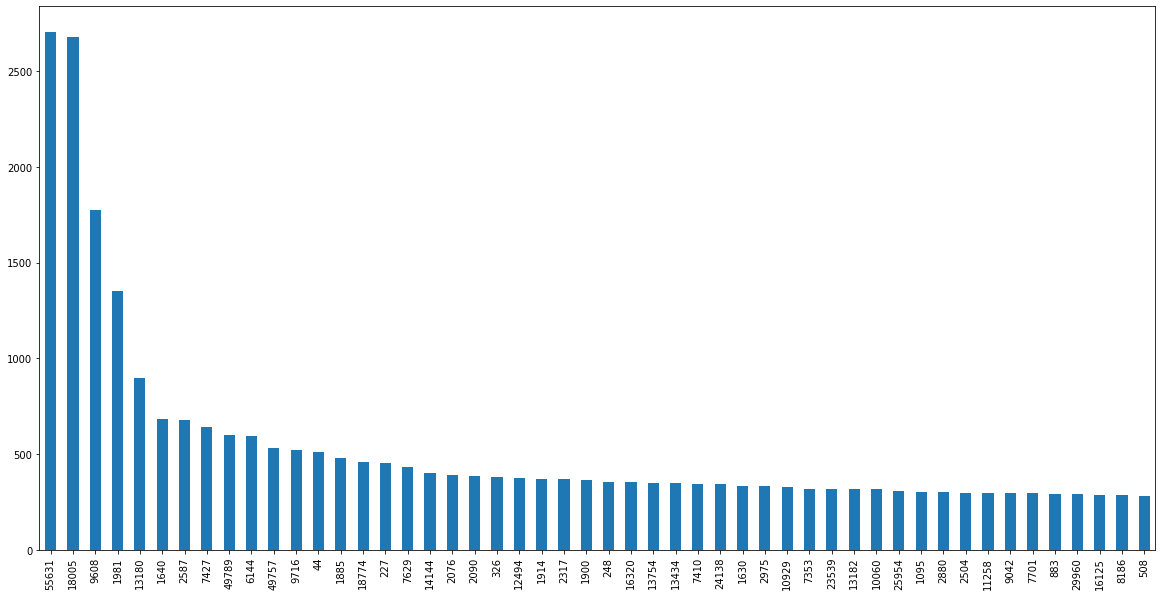

In [19]:
# let's test whether if we exclude music the number of items purchaed/rented by users changes much
# Visualise users by number of purchases/rentals
data[data['CI_ASSET_TYPE'] != 'Music']['LINE_ACCOUNT_ID'].value_counts()[:50].plot(kind='bar')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

# Things change but especially for some specific users that consumer a lot of music

In [20]:
# Let's now explore what user 25 bought...
data[data['LINE_ACCOUNT_ID'] == 25].head(10)

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
25,25,23,"me, myself & irene",Film,Purchase,5.99,2020-02-05 10:07:15
198,25,139,burlesque,Film,Purchase,7.99,2020-02-05 10:22:22
200,25,140,grown ups 2,Film,Purchase,7.99,2020-02-05 10:21:18
201,25,141,grown ups,Film,Purchase,7.99,2020-02-05 10:21:04
383,25,230,shallow grave,Film,Purchase,5.49,2020-02-05 14:35:31
20666,25,1562,goodfellas,Film,Purchase,8.99,2020-01-29 11:11:18
20667,25,1138,gotti,Film,Purchase,8.49,2020-01-29 11:12:40
20737,25,2930,alpha dog,Film,Purchase,6.99,2020-01-29 11:16:57
41404,25,1711,13 going on 30,Film,Purchase,7.99,2019-10-29 19:56:34
49392,25,103,descendants 3,Film,Purchase,10.49,2019-11-09 19:34:39


In [21]:
# Count unique number of users and content items
print('Number of users: {}'.format(data['LINE_ACCOUNT_ID'].nunique()))
print('Number of content items: {}'.format(data['PRODUCT_ID'].nunique()))

Number of users: 299779
Number of content items: 10914


In [22]:
# Let's how things change when we exclude music
data = data[data['CI_ASSET_TYPE'] != 'Music']

print('Number of users: {}'.format(data['LINE_ACCOUNT_ID'].nunique()))
print('Number of content items: {}'.format(data['PRODUCT_ID'].nunique()))

print(data.shape)

Number of users: 297887
Number of content items: 4714
(2215855, 7)


In [23]:
# Let's remove any duplicate rows in case our manipulations created some (or if there were prexisting ones)
data.drop_duplicates(subset=['LINE_ACCOUNT_ID', 'CI_TITLE'], inplace=True)

In [24]:
data.head()

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
1,1,1,it chapter two,Film,Rental,4.49,2020-02-05 00:28:20
2,2,2,legend,Film,Rental,3.50,2020-02-05 00:44:31
3,3,3,the last house on the left,Film,Purchase,7.99,2020-02-05 01:11:34
4,4,4,the mustang,Film,Rental,3.49,2020-02-05 04:33:22
5,5,5,joker,Film,Purchase,15.99,2020-02-05 07:04:24


In [25]:
data['LINE_ACCOUNT_ID'].astype("category").cat.codes

1               1
2               2
3               3
4               4
5               5
            ...  
2284636     56015
2284637     68806
2284638     39447
2284639      6231
2284640    165670
Length: 2021555, dtype: int32

In [26]:
data.head()

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST
1,1,1,it chapter two,Film,Rental,4.49,2020-02-05 00:28:20
2,2,2,legend,Film,Rental,3.50,2020-02-05 00:44:31
3,3,3,the last house on the left,Film,Purchase,7.99,2020-02-05 01:11:34
4,4,4,the mustang,Film,Rental,3.49,2020-02-05 04:33:22
5,5,5,joker,Film,Purchase,15.99,2020-02-05 07:04:24


In [27]:
data.index = pd.to_datetime(data['PURCHASE_TIME_ST'])

data['instance'] = 1

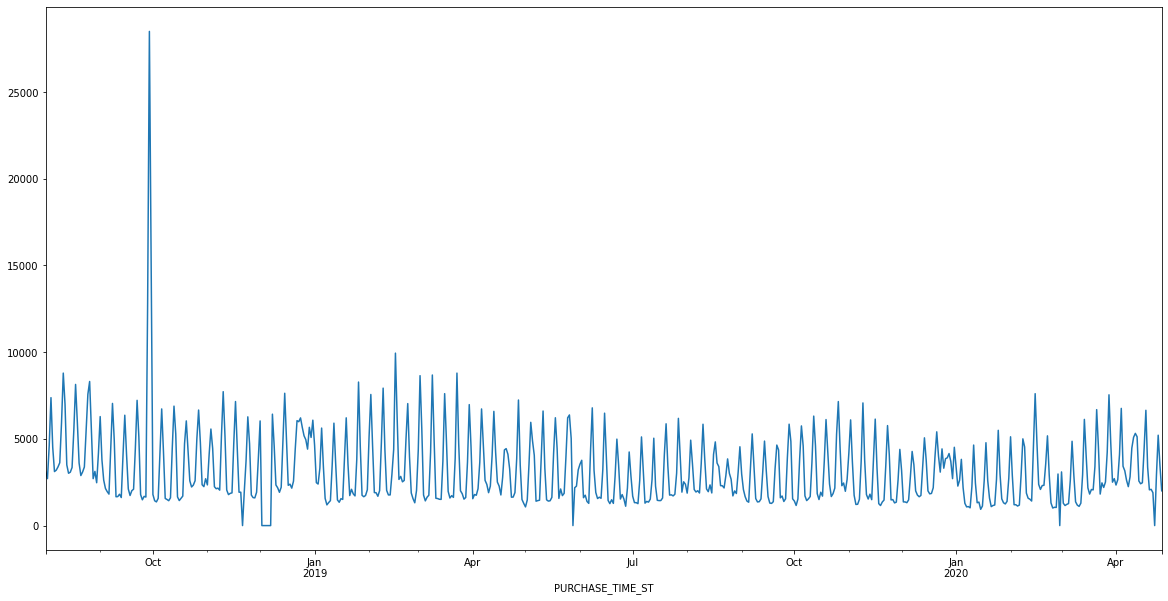

In [28]:
data['instance'].resample('D').sum().plot()

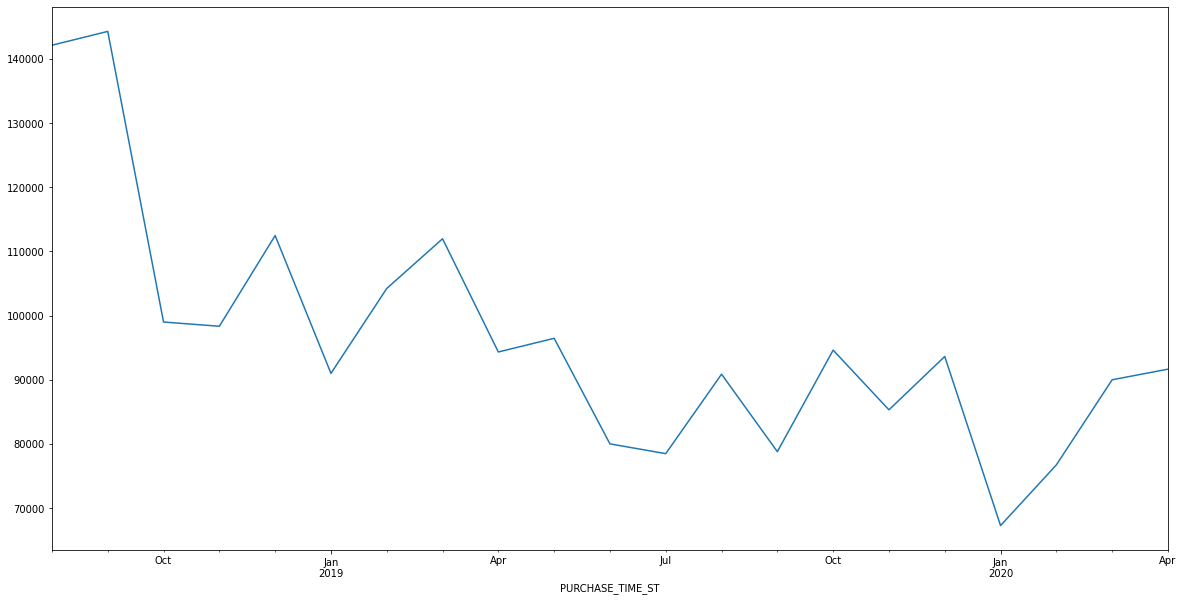

In [29]:
data['instance'].resample('M').sum().plot()

In [30]:
# Create matrices for collab. filtering
data_implicit = data.copy()
#data_implicit.drop(['CI_ASSET_TYPE', 'ENTITLEMENT_TYPE', 'CI_PRICE'], inplace=True)
data_implicit['eventStrength'] = 1

data_implicit['CI_TITLE'] = data_implicit['CI_TITLE'].astype("category")
data_implicit['LINE_ACCOUNT_ID'] = data_implicit['LINE_ACCOUNT_ID'].astype("category")
data_implicit['PRODUCT_ID'] = data_implicit['PRODUCT_ID'].astype("category")
data_implicit['LINE_ACCOUNT_ID'] = data_implicit['LINE_ACCOUNT_ID'].cat.codes
data_implicit['PRODUCT_ID'] = data_implicit['PRODUCT_ID'].cat.codes

sparse_content_person = scipy.sparse.csr_matrix((data_implicit['eventStrength'].astype(float), (data_implicit['PRODUCT_ID'], data_implicit['LINE_ACCOUNT_ID'])))
sparse_person_content = scipy.sparse.csr_matrix((data_implicit['eventStrength'].astype(float), (data_implicit['LINE_ACCOUNT_ID'], data_implicit['PRODUCT_ID'])))

In [31]:
del data

In [32]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

2020-05-01 08:27:47,873 [WARNI]  Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading


In [33]:
alpha = 15
data_tofit = (sparse_content_person * alpha).astype('double')
model.fit(data_tofit)

In [61]:
content_id = 8
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1)) # i.e. calculating abs. value of the vector of each item

scores = content_vecs.dot(content_vecs[content_id]) / content_norms # i.e. calculating cosine similarity, (A.B) / (|A| x |B|)
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

for content in similar:
    idx, score = content
    print(data_implicit['CI_TITLE'].loc[data_implicit['PRODUCT_ID'] == idx].iloc[0])

toy story
toy story 2
toy story 3
cars
frozen
bob the builder: the big dino dig
cars 2
finding nemo
the secret life of pets
trolls


In [53]:
content_vecs.sum(axis=1).shape

(4714,)

In [59]:
data_implicit[data_implicit['CI_TITLE'].str.contains("toy story")].head()
#data_implicit[data_implicit['CI_TITLE']=='frozen']

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST,instance,eventStrength
PURCHASE_TIME_ST,,,,,,,,,
2020-02-05 09:46:49,11,8,toy story,Film,Rental,2.50,2020-02-05 09:46:49,1,1
2020-02-05 08:50:54,21,16,toy story 2,Film,Purchase,9.99,2020-02-05 08:50:54,1,1
2020-02-05 09:34:11,36,8,toy story,Film,Rental,2.50,2020-02-05 09:34:11,1,1
2020-02-05 11:18:14,89,8,toy story,Film,Rental,2.50,2020-02-05 11:18:14,1,1
2020-02-05 10:49:45,36,16,toy story 2,Film,Rental,2.50,2020-02-05 10:49:45,1,1


In [36]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = scipy.sparse.csr_matrix(model.user_factors)
content_vecs = scipy.sparse.csr_matrix(model.item_factors)

# Create recommendations for person with a given id 
person_id = 50

# Number of content items to get
num_contents=10

# Get the interactions scores from the sparse person content matrix
person_interactions = sparse_person_content[person_id,:].toarray()
# Add 1 to everything, so that articles with no interaction yet become equal to 1
person_interactions = person_interactions.reshape(-1) + 1
# Make articles already interacted zero
person_interactions[person_interactions > 1] = 0
# Get dot product of person vector and all content vectors
rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()

# Scale this recommendation vector between 0 and 1
min_max = MinMaxScaler()
rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
# Content already interacted have their recommendation multiplied by zero
recommend_vector = person_interactions * rec_vector_scaled
# Sort the indices of the content into order of best recommendations
content_idx = np.argsort(recommend_vector)[::-1][:num_contents]

# Start empty list to store titles and scores
titles = []
scores = []

for idx in content_idx:
    # Append titles and scores to the list
    titles.append(data_implicit['CI_TITLE'].loc[data_implicit['PRODUCT_ID'] == idx].iloc[0])
    scores.append(recommend_vector[idx])

recommendations = pd.DataFrame({'title': titles, 'score': scores, 'ids' : content_idx})

print(recommendations)

                                          title     score   ids
0                                   toy story 4  1.000000    81
1                                 incredibles 2  0.989042    60
2                                blackkklansman  0.871951  1127
3  harry potter and the deathly hallows: part 2  0.858036   456
4   fantastic beasts: the crimes of grindelwald  0.854490   168
5                     the secret life of pets 2  0.850498   180
6                                    home alone  0.840461  1449
7                     ralph breaks the internet  0.821739   415
8                                    knives out  0.821632  3913
9                                     ocean's 8  0.817490   919


In [37]:
data_implicit[data_implicit['LINE_ACCOUNT_ID']==50].head(10)

,LINE_ACCOUNT_ID,PRODUCT_ID,CI_TITLE,CI_ASSET_TYPE,ENTITLEMENT_TYPE,CI_PRICE,PURCHASE_TIME_ST,instance,eventStrength
PURCHASE_TIME_ST,,,,,,,,,
2020-02-05 00:26:55,50,40,insidious,Film,Rental,3.50,2020-02-05 00:26:55,1,1
2020-01-27 21:14:55,50,767,daddy's home,Film,Rental,3.50,2020-01-27 21:14:55,1,1
2020-03-26 02:51:44,50,2066,the interview,Film,Rental,2.99,2020-03-26 02:51:44,1,1
2020-04-03 18:31:14,50,729,22 jump street,Film,Rental,3.49,2020-04-03 18:31:14,1,1
2020-02-09 06:58:39,50,115,once upon a time in hollywood,Film,Rental,4.49,2020-02-09 06:58:39,1,1
2020-04-26 01:49:23,50,2027,national treasure,Film,Rental,3.50,2020-04-26 01:49:23,1,1
2019-07-31 20:42:11,50,716,what men want,Film,Rental,4.49,2019-07-31 20:42:11,1,1
2019-07-16 23:42:52,50,996,us,Film,Purchase,11.99,2019-07-16 23:42:52,1,1
2020-03-15 16:18:09,50,155,storks,Film,Rental,3.50,2020-03-15 16:18:09,1,1


In [38]:
%%time
def precision_at_k(data_implicit, k=5):
    '''
    No splitting between training and test sample
    '''
    
    user_index = data_implicit['LINE_ACCOUNT_ID'].unique().tolist()
        
    precisions = []
    
    for user in user_index:
        
        # Make k_tmp back to original k number for next iteration of loop
        k_tmp = k
        
        n_users_tmp = len(data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user])
        if k >= n_users_tmp: # make k temporarily smaller for users that haven't watched a k number of items
            k_tmp = n_users_tmp
       
        # Get the interactions scores from the sparse person content matrix
        person_interactions = sparse_person_content[user,:].toarray()
        # Add 1 to everything, so that articles with no interaction yet become equal to 1
        person_interactions = person_interactions.reshape(-1) + 1

        # Make articles already interacted zero 
        person_interactions[person_interactions > 1] = 0

        # Get dot product of person vector and all content vectors
        rec_vector = person_vecs[user,:].dot(content_vecs.T).toarray()
        
        recommend_vector = person_interactions * rec_vector.reshape(-1,1)[:,0]
        # Sort the indices of the content into order of best recommendations
        top_k = np.argsort(recommend_vector)[::-1][:k_tmp]

        labels = data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user]['PRODUCT_ID']

        precision = float(len(set(top_k) & set(labels))) / float(k_tmp)
        precisions.append(precision)
        
    return np.mean(precisions) 

k = 5
patk = round(precision_at_k(data_implicit, k=k)*100, 2)
#
print('Precision @ k={}: {}%'.format(k, patk))

KeyboardInterrupt: 

In [40]:
user = 10
k = 5

In [42]:
# Make k_tmp back to original k number for next iteration of loop
k_tmp = k

n_users_tmp = len(data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user])
if k >= n_users_tmp: # make k temporarily smaller for users that haven't watched a k number of items
    k_tmp = n_users_tmp

# Get the interactions scores from the sparse person content matrix
person_interactions = sparse_person_content[user,:].toarray()
# Add 1 to everything, so that articles with no interaction yet become equal to 1
person_interactions = person_interactions.reshape(-1) + 1

########################################   HERE WHAT ALREADY WATCHED (CURRENTLY >1) MAKE IT BACK TO 1 TO AVOID BIAS WHEN CALCULATING SCORES - will need possibly to change it again in some form if we split train and test datasets
# Make articles already interacted zero 
person_interactions[person_interactions > 1] = 0
########################################

# Get dot product of person vector and all content vectors
rec_vector = person_vecs[user,:].dot(content_vecs.T).toarray()

recommend_vector = person_interactions * rec_vector.reshape(-1,1)[:,0]
# Sort the indices of the content into order of best recommendations
top_k = np.argsort(recommend_vector)[::-1][:k_tmp]

labels = data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user]['PRODUCT_ID']

precision = float(len(set(top_k) & set(labels))) / float(k_tmp)

In [47]:
print(set(np.argsort(recommend_vector)[::-1][:k_tmp]) ==  set(rec_matrix[user,-k_tmp:]))

True


In [147]:
del person_interactions_matrix
del rec_matrix

In [46]:
# Get the interactions scores from the sparse person content matrix
person_interactions_matrix = sparse_person_content.toarray() + 1

person_interactions_matrix[person_interactions_matrix > 1] = 0

# Get dot product of person vector and all content vectors
rec_matrix = person_vecs.dot(content_vecs.T)

rec_matrix = rec_matrix.toarray()

rec_matrix = person_interactions_matrix * rec_matrix

del person_interactions_matrix

rec_matrix = np.argsort(rec_matrix, axis=1)

In [48]:
%%time
def precision_at_k(data_implicit, k=5):
    '''
    No splitting between training and test sample
    --> matrix multiplication at once, not user by user to make it faster
    '''
    
    user_index = data_implicit['LINE_ACCOUNT_ID'].unique().tolist()
        
    precisions = []

    for user in user_index:
        
        # Make k_tmp back to original k number for next iteration of loop
        k_tmp = k
        
        n_users_tmp = len(data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user])
        if k >= n_users_tmp: # make k temporarily smaller for users that haven't watched a k number of items
            k_tmp = n_users_tmp
       
        # Sort the indices of the content into order of best recommendations
        top_k = rec_matrix[user,-k_tmp:]

        labels = data_implicit[data_implicit['LINE_ACCOUNT_ID'] == user]['PRODUCT_ID']

        precision = float(len(set(top_k) & set(labels))) / float(k_tmp)
        precisions.append(precision)
    
    return np.mean(precisions) 

k = 5
patk = round(precision_at_k(data_implicit, k=k)*100, 2)
#
print('Precision @ k={}: {}%'.format(k, patk))

Precision @ k=5: 50.44%
CPU times: user 16min 47s, sys: 0 ns, total: 16min 47s
Wall time: 16min 47s


In [ ]:
%%time
# Precision at k splitting training sample to test + comparison with random recommendations 
import random
def precision_at_k(data_implicit, k=5):
    '''
    Splitting between training and test sample
    + performance of random recommender
    + performance of popularity recommender
    '''
    
    # Use as traning sample all activity before 2020
    date_threshold = '2020-01-01'
    data_train = data_implicit[data_implicit['PURCHASE_TIME_ST'] < date_threshold]
    sparse_person_content_tmp = scipy.sparse.csr_matrix((data_train['eventStrength'].astype(float), (data_train['LINE_ACCOUNT_ID'], data_train['PRODUCT_ID'])))
    
    user_index = data_train['LINE_ACCOUNT_ID'].unique().tolist()
    
    # Get product IDs ordered by popularity between threshold date and 1 month before
    list_full_popular = data_train[data_train['PURCHASE_TIME_ST'] >= '2019-12-01']['PRODUCT_ID'].value_counts().index.tolist()
        
    precisions = []
    precisions_random = []
    precisions_popular = []
    
    for user in user_index:
        
        # Make k_tmp back to original k number for next iteration of loop
        k_tmp = k
        
        n_users_tmp = len(data_train[data_train['LINE_ACCOUNT_ID'] == user])
        if k >= n_users_tmp: # make k temporarily smaller for users that haven't watched a k number of items
            k_tmp = n_users_tmp
       
        # Get the interactions scores from the sparse person content matrix
        person_interactions = sparse_person_content_tmp[user,:].toarray()
        # Add 1 to everything, so that articles with no interaction yet become equal to 1
        person_interactions = person_interactions.reshape(-1) + 1

        # Make articles already interacted zero 
        person_interactions[person_interactions > 1] = 0

        # Get dot product of person vector and all content vectors
        rec_vector = person_vecs[user,:].dot(content_vecs.T).toarray()
        
        recommend_vector = person_interactions * rec_vector.reshape(-1,1)[:,0]
        # Sort the indices of the content into order of best recommendations
        top_k = np.argsort(recommend_vector)[::-1][:k_tmp]
        
        # These are labels of what actually pucrhased/rented since the start of 2020
        labels = data_implicit[(data_implicit['PURCHASE_TIME_ST'] >= date_threshold) & (data_implicit['LINE_ACCOUNT_ID'] == user)]['PRODUCT_ID']

        precision = float(len(set(top_k) & set(labels))) / float(k_tmp)
        precisions.append(precision)
        
        ## Get same number of labels as before but selected at random from full list of product IDs
        list_full = data_implicit['PRODUCT_ID'].unique()
        list_train = data_train[data_train['LINE_ACCOUNT_ID'] == user]['PRODUCT_ID'].tolist()
        list_not_watched = [x for x in list_full if x not in list_train] # remove the IDs already watched in the training sample
        labels_random = random.sample(list_not_watched, len(labels))
        #
        precision_random = float(len(set(top_k) & set(labels_random))) / float(k_tmp)
        precisions_random.append(precision_random)
        
        ## Get same number of labels but for popular items, ordered by popularity
        list_not_watched_popular = [x for x in list_full_popular if x not in list_train] # remove the IDs already watched in the training sample
        labels_popular = list_not_watched_popular[:len(labels)]
        #
        precision_popular = float(len(set(top_k) & set(labels_popular))) / float(k_tmp)
        precisions_popular.append(precision_popular)
        
    return np.mean(precisions), np.mean(precisions_random), np.mean(precisions_popular)

k = 5
patk, patk_random, patk_popular = precision_at_k(data_implicit, k=k)
#
print('Precision @ k={}: {}%'.format(k, round(patk*100,2)))
print('Precision @ k={} for a recommender at random: {}%'.format(k, round(patk_random*100,2)))
print('Precision @ k={} for a popularity recommender: {}%'.format(k, round(patk_popular*100,2)))

with open("patk.txt", "w") as output:
    output.write(str([patk, patk_random, patk_popular]))

In [ ]:
data_implicit['PRODUCT_ID']

In [ ]:
# Set up a grid search
num_factors = [10, 20, 40, 80, 120]
regularization = [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2]
alpha = [1, 10, 50, 100, 500, 1000]

# num_factors = [10, 20]
# regularization = [1e2]
# alpha = [1, 10]

k = 5

results_num_factors = []
results_regularization = []
results_alpha = []
results_patk = []

for n in num_factors:
    for r in regularization:
        for a in alpha:
            
            model = implicit.als.AlternatingLeastSquares(factors=n, regularization=r, iterations=50)
            
            data_tofit = (sparse_content_person * a).astype('double')
            model.fit(data_tofit)
            
            person_vecs = scipy.sparse.csr_matrix(model.user_factors)
            content_vecs = scipy.sparse.csr_matrix(model.item_factors)
            
            patk = precision_at_k(data_implicit, k=k)
            
            results_num_factors.append(n)
            results_regularization.append(r)
            results_alpha.append(a)
            results_patk.append(patk)  
            
results_grid_search = pd.DataFrame({
    'Precision@k' : results_patk,
    'NumFactors' : results_num_factors,
    'Regularization' : results_regularization,
    'Alpha' : results_alpha
})
            
results_grid_search.to_csv('results_grid_search_ALS.csv', index=False)

In [ ]:
data_implicit.loc[data_implicit['LINE_ACCOUNT_ID'] == 67].sort_values(by=['eventStrength'], ascending=False)[['CI_TITLE', 'LINE_ACCOUNT_ID', 'eventStrength']].head(10)

,CI_TITLE,LINE_ACCOUNT_ID,eventStrength
PURCHASE_TIME_ST,,,
2019-10-16 00:29:50,red sparrow,67,1
2019-09-09 10:46:07,aquaman,67,1
2019-10-27 05:04:36,spider-man: far from home,67,1
2019-09-20 22:53:36,shazam!,67,1
2019-10-15 22:45:56,x-men: dark phoenix,67,1
2018-12-18 20:23:35,harry potter and the deathly hallows: part 2,67,1


In [38]:
# Calculate sparsity (may want above 0.1%...)
n_users = data_implicit['LINE_ACCOUNT_ID'].unique().shape[0]
n_items = data_implicit['PRODUCT_ID'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of items: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(data_implicit.shape[0]) / float(n_users*n_items) * 100))

Number of users: 297887
Number of items: 4714
Sparsity: 0.144%


In [41]:
# Calculate how many users have watched X% of the content
idx = data_implicit['LINE_ACCOUNT_ID'].value_counts().index.tolist()
counts = data_implicit['LINE_ACCOUNT_ID'].value_counts().tolist()

user_count = []
percentage_activity = []
activity_so_far = 0
total_activity = sum(counts)

for u in range(len(idx)):
    
    user_count.append(u+1)
    
    activity_so_far = activity_so_far + counts[u]
    percentage_so_far = activity_so_far / total_activity * 100
    percentage_activity.append(percentage_so_far)
    

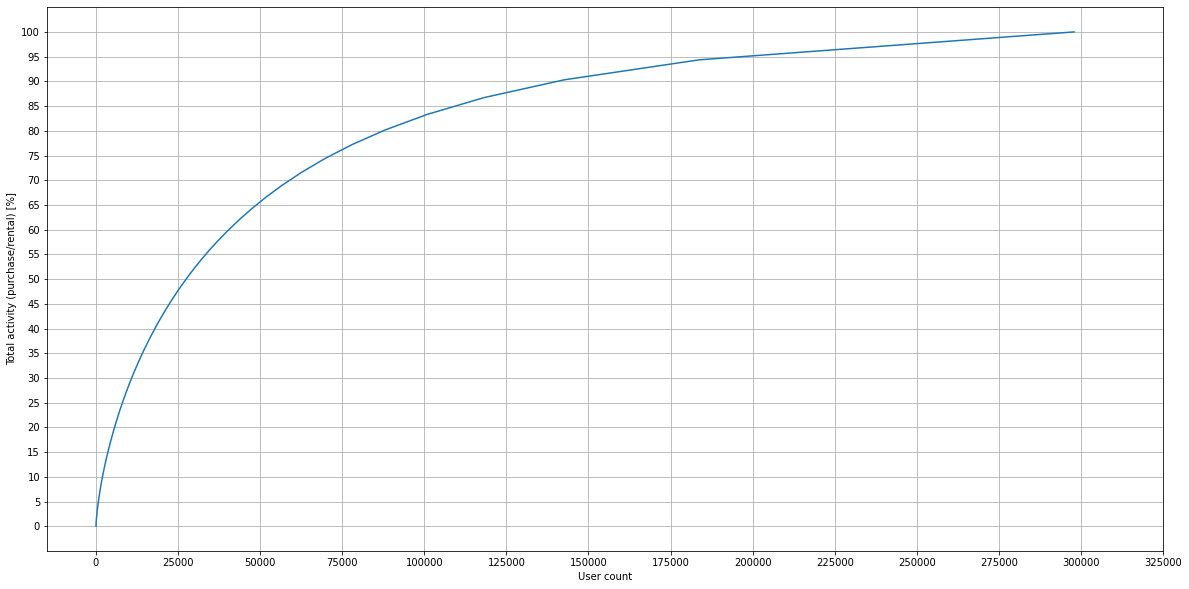

In [42]:
import matplotlib.pyplot as plt

plt.plot(user_count, percentage_activity)
plt.xlabel('User count')
plt.ylabel('Total activity (purchase/rental) [%]')
plt.grid()
plt.yticks(np.arange(0,105, 5))
plt.xticks(np.arange(0,350000, 25000))
plt.show()